In [18]:
import glob
import os
import pickle
import time

import numpy as np
from moviepy.editor import VideoFileClip
from scipy.ndimage.measurements import label
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.utils import shuffle

import cv2
import featurelib as lib
import searchlib as searchlib

%matplotlib inline
# Read in the image
image = mpimg.imread('sample/cutout1.jpg')

# Take histograms in R, G, and B
rhist = np.histogram(image[:,:,0], bins=32, range=(0, 256))
ghist = np.histogram(image[:,:,1], bins=32, range=(0, 256))
bhist = np.histogram(image[:,:,2], bins=32, range=(0, 256))

In [2]:
print (rhist)

(array([400, 441, 302, 244, 189, 283, 412, 433, 239, 177, 209, 302, 276,
       179, 129, 106, 104, 111, 106,  96, 111, 123, 139, 130, 167, 164,
       149, 156, 222, 268, 258,  53]), array([   0.,    8.,   16.,   24.,   32.,   40.,   48.,   56.,   64.,
         72.,   80.,   88.,   96.,  104.,  112.,  120.,  128.,  136.,
        144.,  152.,  160.,  168.,  176.,  184.,  192.,  200.,  208.,
        216.,  224.,  232.,  240.,  248.,  256.]))


    Finding histogram


In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image = mpimg.imread('cutout1.jpg')

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the RGB channels separately
    rhist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    ghist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    bhist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Generating bin centers
    bin_edges = rhist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return rhist, ghist, bhist, bin_centers, hist_features
    
rh, gh, bh, bincen, feature_vec = color_hist(image, nbins=32, bins_range=(0, 256))

# Plot a figure with all three bar charts
if rh is not None:
    fig = plt.figure(figsize=(12,3))
    plt.subplot(131)
    plt.bar(bincen, rh[0])
    plt.xlim(0, 256)
    plt.title('R Histogram')
    plt.subplot(132)
    plt.bar(bincen, gh[0])
    plt.xlim(0, 256)
    plt.title('G Histogram')
    plt.subplot(133)
    plt.bar(bincen, bh[0])
    plt.xlim(0, 256)
    plt.title('B Histogram')
    fig.tight_layout()
else:
    print('Your function is returning None for at least one variable...')

In [ ]:
# Explore color spaces

In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot3d(pixels, colors_rgb,
        axis_labels=list("RGB"), axis_limits=[(0, 255), (0, 255), (0, 255)]):
    """Plot pixels in 3D."""

    # Create figure and 3D axes
    fig = plt.figure(figsize=(8, 8))
    ax = Axes3D(fig)

    # Set axis limits
    ax.set_xlim(*axis_limits[0])
    ax.set_ylim(*axis_limits[1])
    ax.set_zlim(*axis_limits[2])

    # Set axis labels and sizes
    ax.tick_params(axis='both', which='major', labelsize=14, pad=8)
    ax.set_xlabel(axis_labels[0], fontsize=16, labelpad=16)
    ax.set_ylabel(axis_labels[1], fontsize=16, labelpad=16)
    ax.set_zlabel(axis_labels[2], fontsize=16, labelpad=16)

    # Plot pixel values with colors given in colors_rgb
    ax.scatter(
        pixels[:, :, 0].ravel(),
        pixels[:, :, 1].ravel(),
        pixels[:, :, 2].ravel(),
        c=colors_rgb.reshape((-1, 3)), edgecolors='none')

    return ax  # return Axes3D object for further manipulation

def explore_image(name):
    # Read a color image
    img = cv2.imread("sample/"+name)

    # Select a small fraction of pixels to plot by subsampling it
    scale = max(img.shape[0], img.shape[1], 64) / 64  # at most 64 rows and columns
    img_small = cv2.resize(img, (np.int(img.shape[1] / scale), np.int(img.shape[0] / scale)), interpolation=cv2.INTER_NEAREST)

    # Convert subsampled image to desired color space(s)
    img_small_RGB = cv2.cvtColor(img_small, cv2.COLOR_BGR2RGB)  # OpenCV uses BGR, matplotlib likes RGB
    img_small_HSV = cv2.cvtColor(img_small, cv2.COLOR_BGR2HSV)
    img_small_LUV = cv2.cvtColor(img_small, cv2.COLOR_BGR2Luv)
    img_small_HLS = cv2.cvtColor(img_small, cv2.COLOR_BGR2HLS)
    img_small_rgb = img_small_RGB / 255.  # scaled to [0, 1], only for plotting

    # Plot and show
    plot3d(img_small_RGB, img_small_rgb)
    plt.show()

    plot3d(img_small_HSV, img_small_rgb, axis_labels=list("HSV"))
    plt.show()

    plot3d(img_small_LUV, img_small_rgb, axis_labels=list("Luv"))
    plt.show()
    
    plot3d(img_small_HLS, img_small_rgb, axis_labels=list("HLS"))
    plt.show()

In [14]:
# Testing out color explore
explore_image("000275.png")

In [15]:
explore_image("car_53.png")

In [16]:
explore_image("not_3.png")

# Spatial Binning of the image

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Read in an image
# You can also read cutout2, 3, 4 etc. to see other examples
image = mpimg.imread('cutout1.jpg')

# Define a function to compute color histogram features  
# Pass the color_space flag as 3-letter all caps string
# like 'HSV' or 'LUV' etc.
# KEEP IN MIND IF YOU DECIDE TO USE THIS FUNCTION LATER
# IN YOUR PROJECT THAT IF YOU READ THE IMAGE WITH 
# cv2.imread() INSTEAD YOU START WITH BGR COLOR!
def bin_spatial(img, color_space='RGB', size=(32, 32)):
    # Convert image to new color space (if specified)
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)             
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(feature_image, size).ravel() 
    # Return the feature vector
    return features
    
feature_vec = bin_spatial(image, color_space='RGB', size=(32, 32))

# Plot features
plt.plot(feature_vec)
plt.title('Spatially Binned Features')

# More stuff

Using: 12 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 7872
0.45 Seconds to train SVC...
Test Accuracy of SVC =  0.9957


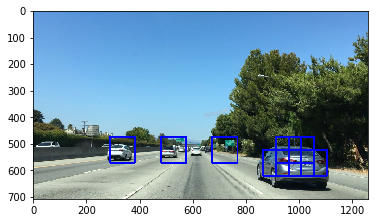

In [26]:
# pylint: disable=I0011,E1101,C0111,C0103,C0301,W0611,R0914,R0902,R0903,R0913,E0401
import glob
import time

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
from skimage.feature import hog
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

import cv2
from lesson_functions import *


# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images


def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9,
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # 1) Define an empty list to receive features
    img_features = []
    # 2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else:
        feature_image = np.copy(img)
    # 3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # 4) Append features to list
        img_features.append(spatial_features)
    # 5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        # 6) Append features to list
        img_features.append(hist_features)
    # 7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:, :, channel],
                                                     orient, pix_per_cell, cell_per_block,
                                                     vis=False, feature_vec=True))
        else:
            hog_features = get_hog_features(feature_image[:, :, hog_channel], orient,
                                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # 8) Append features to list
        img_features.append(hog_features)

    # 9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image
# and the list of windows to be searched (output of slide_windows())


def search_windows(img, windows, clf, scaler, color_space='RGB',
                   spatial_size=(32, 32), hist_bins=32,
                   hist_range=(0, 256), orient=9,
                   pix_per_cell=8, cell_per_block=2,
                   hog_channel=0, spatial_feat=True,
                   hist_feat=True, hog_feat=True):

    # 1) Create an empty list to receive positive detection windows
    on_windows = []
    # 2) Iterate over all windows in the list
    for window in windows:
        # 3) Extract the test window from original image
        test_img = cv2.resize(
            img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        # 4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space,
                                       spatial_size=spatial_size, hist_bins=hist_bins,
                                       orient=orient, pix_per_cell=pix_per_cell,
                                       cell_per_block=cell_per_block,
                                       hog_channel=hog_channel, spatial_feat=spatial_feat,
                                       hist_feat=hist_feat, hog_feat=hog_feat)
        # 5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        # 6) Predict using your classifier
        prediction = clf.predict(test_features)
        # 7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    # 8) Return windows for positive detections
    return on_windows


def main():
    # Read in cars and notcars
    images = glob.glob("data/smaller/**/*.jpeg", recursive=True)
    cars = []
    notcars = []
    for image in images:
        if 'onlyvehicles' in image:
            cars.append(image)
        elif 'non-vehicles' in image:
            notcars.append(image)
    
#     # Reduce the sample size because
#     # The quiz evaluator times out after 13s of CPU time
#     sample_size = 500
#     cars = cars[0:sample_size]
#     notcars = notcars[0:sample_size]

    # TODO: Tweak these parameters and see how the results change.
    color_space = 'LUV'  # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 12  # HOG orientations
    pix_per_cell = 8  # HOG pixels per cell
    cell_per_block = 2  # HOG cells per block
    hog_channel = "ALL"  # Can be 0, 1, 2, or "ALL"
    spatial_size = (16, 16)  # Spatial binning dimensions
    hist_bins = 16    # Number of histogram bins
    spatial_feat = True  # Spatial features on or off
    hist_feat = True  # Histogram features on or off
    hog_feat = True  # HOG features on or off
    y_start_stop = [475, None]  # Min and max in y to search in slide_window()

    car_features = extract_features(cars, color_space=color_space,
                                    spatial_size=spatial_size, hist_bins=hist_bins,
                                    orient=orient, pix_per_cell=pix_per_cell,
                                    cell_per_block=cell_per_block,
                                    hog_channel=hog_channel, spatial_feat=spatial_feat,
                                    hist_feat=hist_feat, hog_feat=hog_feat)
    notcar_features = extract_features(notcars, color_space=color_space,
                                       spatial_size=spatial_size, hist_bins=hist_bins,
                                       orient=orient, pix_per_cell=pix_per_cell,
                                       cell_per_block=cell_per_block,
                                       hog_channel=hog_channel, spatial_feat=spatial_feat,
                                       hist_feat=hist_feat, hog_feat=hog_feat)

    X = np.vstack((car_features, notcar_features)).astype(np.float64)
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state=rand_state)

    print('Using:', orient, 'orientations', pix_per_cell,
          'pixels per cell and', cell_per_block, 'cells per block')
    print('Feature vector length:', len(X_train[0]))
    # Use a linear SVC
    svc = LinearSVC()
    # Check the training time for the SVC
    t = time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2 - t, 2), 'Seconds to train SVC...')
    # Check the score of the SVC
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    # Check the prediction time for a single sample
    t = time.time()

    image = mpimg.imread('sample/bbox-example-image.jpg')
    draw_image = np.copy(image)

    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    #image = image.astype(np.float32)/255

    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop,
                           xy_window=(96, 96), xy_overlap=(0.5, 0.5))

    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space,
                                 spatial_size=spatial_size, hist_bins=hist_bins,
                                 orient=orient, pix_per_cell=pix_per_cell,
                                 cell_per_block=cell_per_block,
                                 hog_channel=hog_channel, spatial_feat=spatial_feat,
                                 hist_feat=hist_feat, hog_feat=hog_feat)

    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)

    plt.imshow(window_img)

main()